In [3]:
import git
repo = git.Repo("./", search_parent_directories=True)

# Data Preparation

## Directory

In [4]:
homedir = repo.working_dir
datadir = f"{homedir}/data/"

## international/health

In [5]:
import pandas as pd
df = pd.read_csv(datadir + 'international/health/hospital-beds-per-1000-people.csv')

In [6]:
X=df.pivot(index="Entity",columns="Year",values="Hospital beds (per 1,000 people) (per 1,000 people)")

# SIR solver

In [32]:
def seirqd(dat, t,params, N):
    beta = params[0] / N
    delta = params[1]
    gamma = params[2]
    alpha = params[3]
    lambda_ = params[4]
    kappa = params[5]
    
    s = dat[0]
    e = dat[1]
    i = dat[2]
    q = dat[3]
    r = dat[4]
    d = dat[5]
    sa = dat[6]
    
    dsdt = - beta * s * i - alpha * s
    dedt = beta * s * i - gamma * e
    didt = gamma * e - lambda_ * i
    dqdt = lambda_ * i - delta * q - kappa * q
    drdt = delta * q
    dddt = kappa * q
    dsadt = alpha * s
    
    # susceptible, exposed, infected, quarantined, recovered, died, unsusceptible
    return [dsdt, dedt, didt, dqdt, drdt, dddt, dsadt]

In [125]:
from scipy.integrate import odeint
def model_qd(params, data, tmax=-1):
    # initial conditions
    #N = data['Population'].values[0] # total population
    N = 8.3e07
    initial_conditions = N * np.array(params[-5:]) # the parameters are a fraction of the population so multiply by the population
    
    # initial conditions
    e0 = initial_conditions[0]
    i0 = initial_conditions[1]
    q0 = initial_conditions[2]
    r0 = initial_conditions[3]
    sa0 = initial_conditions[4]
    
    d0 = data.iloc[0]
    s0 = N - np.sum(initial_conditions) - d0

    yz_0 = np.array([s0, e0, i0, q0, r0, d0, sa0])
    
    # Package parameters into a tuple
    args = (params, N)
    
    n = len(data)
    if tmax > 0:
        n = tmax
    
    # Integrate ODEs
    s = odeint(seirqd, yz_0, np.arange(0, n), args=args)

    return s

In [104]:
def fit_leastsq_qd(params, data):
    Ddata = data
    # Idata = (data['TotalCurrentlyPositive'].values)
    s = model_qd(params, data)
    s = model_qd(params, data)
    D = s[:,5]
    error = (D-Ddata)
    return error

In [56]:
params = [2.0, 0.3, 0.2, 0.05, 0.2, 0.03]
initial_conditions = [0.5e-3, 0.5e-3, 0.3e-3, 0.1e-4, 0.5]
param_ranges = [(0.5, 3.0), (0.0, 0.5), (0.0, 0.5), (0.01, 0.5), (0.0, 0.5), (0.005, 0.1)]
initial_ranges = [(1.0e-7, 0.01), (1.0e-7, 0.01), (1.0e-7, 0.01), (1.0e-7, 0.01), (1.0e-7, 0.9)]
guesses = params + initial_conditions
ranges = param_ranges + initial_ranges

In [13]:
def select_region(df, region, min_deaths=50):
    d = df.loc[df['Region'] == region]
    start = np.where(d['Deaths'].values > min_deaths)[0][0]
    d = d[start:]
    return d

In [16]:
import pandas as pd

In [38]:
df = pd.read_csv(datadir + 'international/italy/covid/dpc-covid19-ita-regioni.csv')

In [39]:
populations = pd.read_csv(datadir + 'international/italy/demographics/region-populations.csv')
def get_population(region):
    if region == 'Emilia-Romagna':
        region = 'Emilia Romagna'
    return populations[populations['Region'] == region]['Population'].values[0]

In [40]:
df['Population'] = df.apply(lambda row: get_population(row.Region), axis=1)

In [41]:
df.shape

(1071, 20)

In [26]:
import scipy

In [60]:
res = []
for i in range(500, 1000, 50):
    res.append(least_squares(fit_leastsq_qd, guesses, args=(select_region(df[:i], 'Lombardia'),), bounds=np.transpose(np.array(ranges)))['x'])

In [50]:
res=least_squares(fit_leastsq_qd, guesses, args=(select_region(df, 'Lombardia'),), bounds=np.transpose(np.array(ranges)))

In [57]:
guesses

[2.0, 0.3, 0.2, 0.05, 0.2, 0.03, 0.0005, 0.0005, 0.0003, 1e-05, 0.5]

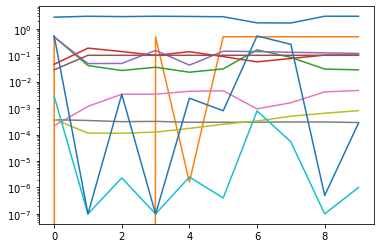

In [79]:
plt.yscale('log')
plt.plot(np.array(res).round(7))

In [46]:
res[0]

 active_mask: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        cost: 369081.76522783213
         fun: array([   0.        ,   21.50890189,   35.16402459,   39.60479744,
         68.65707123,   13.79076027,   19.15163702,  -28.35735321,
        -71.05158881,  -70.50193438,  -65.61720319,   34.24686971,
        -15.83010024,   10.55671845,   45.04942784,    5.473961  ,
         43.4122788 , -127.3549345 , -104.32808521,  115.60185858,
        -58.08551071,  -27.55374677, -388.96958657,  520.1711332 ,
        108.59891704,  -38.53080959,  150.36716158, -140.08406383,
       -107.07778247,   38.98716199, -317.53774317,  270.58012839])
        grad: array([  -29888.66345475,    -5873.50305874,   -38785.42262854,
         649720.41843124,   110667.83381664,    43364.78841689,
       -1903084.00669098,   220922.29938126,   420617.57403833,
         161008.66322361,   161008.66322361])
         jac: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000

# Inference

## from beds(international)

In [14]:
X=df.pivot(index="Entity",columns="Year",values="Hospital beds (per 1,000 people) (per 1,000 people)")

In [17]:
max_beds=X.T.max()

In [127]:
max_beds

Entity
Afghanistan    0.500000
Albania        5.102676
Algeria        3.187407
Andorra        3.300000
Angola         2.721000
                 ...   
Vietnam        3.832900
World          4.125667
Yemen          0.865500
Zambia         3.482200
Zimbabwe       3.876646
Length: 245, dtype: float64

In [24]:
df_covid=pd.read_csv(datadir+'international/covid/our_world_in_data/full_data.csv')

In [25]:
df_covid

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2019-12-31,Afghanistan,0,0,0,0
1,2020-01-01,Afghanistan,0,0,0,0
2,2020-01-02,Afghanistan,0,0,0,0
3,2020-01-03,Afghanistan,0,0,0,0
4,2020-01-04,Afghanistan,0,0,0,0
...,...,...,...,...,...,...
10843,2020-04-10,Zimbabwe,0,1,11,3
10844,2020-04-11,Zimbabwe,0,0,11,3
10845,2020-04-12,Zimbabwe,3,0,14,3
10846,2020-04-13,Zimbabwe,0,0,14,3


In [36]:
Y_d=df_covid.pivot(index="location",columns="date",values="total_deaths")
Y_i=df_covid.pivot(index="location",columns="date",values="total_cases")

In [129]:
Y_i.sort_values(by='2020-04-14').iloc[-100:-1]

date,2019-12-31,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,...,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14
location,,,,,,,,,,,,,,,,,,,,,
Malta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,213.0,234.0,241.0,293.0,299.0,337.0,350.0,370.0,378.0,384.0
Jordan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,323.0,345.0,349.0,349.0,358.0,372.0,372.0,381.0,389.0,391.0
Taiwan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,363.0,363.0,373.0,376.0,379.0,380.0,380.0,385.0,388.0,393.0
Honduras,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,268.0,298.0,305.0,312.0,343.0,382.0,392.0,393.0,397.0,407.0
Kyrgyzstan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,144.0,216.0,228.0,270.0,280.0,298.0,339.0,377.0,419.0,430.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Germany,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,91714.0,95391.0,99225.0,103228.0,108202.0,113525.0,117658.0,120479.0,123016.0,125098.0
Italy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,124632.0,128948.0,132547.0,135586.0,139422.0,143626.0,147577.0,152271.0,156363.0,159516.0
Spain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,124736.0,130759.0,135032.0,140510.0,146690.0,152446.0,157022.0,161852.0,166019.0,169496.0


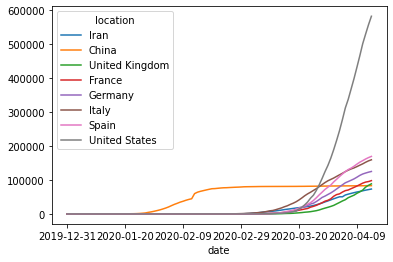

In [99]:
Y_i.sort_values(by='2020-04-14').iloc[-10:-2].T.plot()

In [38]:
guesses = [2.0, 0.3, 0.2, 0.05, 0.2, 0.03] + [0.5e-3, 0.5e-3, 0.3e-3, 0.1e-4, 0.5]
ranges = [(0.5, 3.0), (0.0, 0.5), (0.0, 0.5), (0.01, 0.5), (0.0, 0.5), (0.005, 0.1)]+[(1.0e-7, 0.01), (1.0e-7, 0.01), (1.0e-7, 0.01), (1.0e-7, 0.01), (1.0e-7, 0.9)]

In [126]:
from scipy.optimize import least_squares
res=least_squares(fit_leastsq_qd, 
              guesses, 
              args=(Y_d.loc['Germany'],),
              bounds=np.transpose(np.array(ranges))
             )['x']

In [103]:
fit_leastsq_qd(guesses, Y_d.loc['Iran'])

date
2019-12-31       0.0
2020-01-01       0.0
2020-01-02       0.0
2020-01-03       0.0
2020-01-04       0.0
               ...  
2020-04-10    4110.0
2020-04-11    4232.0
2020-04-12    4357.0
2020-04-13    4474.0
2020-04-14    4585.0
Name: Iran, Length: 106, dtype: float64

In [120]:
import itertools

import bokeh.io
import bokeh.application
import bokeh.application.handlers
import bokeh.models
import bokeh.plotting
from bokeh.models import Span
bokeh.io.output_notebook()
def plot_qd(res, data, extrapolate=1, boundary=None, plot_infectious=False):

    s = model_qd(res, data, len(data)*extrapolate)
    S = s[:,0]
    E = s[:,1]
    I = s[:,2]
    Q = s[:,3]
    R = s[:,4]
    D = s[:,5]
    SA = s[:,6]

    t = np.arange(0, len(data))
    tp = np.arange(0, len(data)*extrapolate)

    p = bokeh.plotting.figure(plot_width=600,
                              plot_height=400,
                             title = 'SEIR-QD Model',
                             x_axis_label = 't (days)',
                             y_axis_label = '# people')

    if plot_infectious:
        p.line(tp, I, color = 'red', line_width = 1, legend_label = 'All infected')
    p.line(tp, D, color = 'black', line_width = 1, legend_label = 'Deceased')

    # death
    p.circle(t, data, color ='black')
    
    if boundary is not None:
        vline = Span(location=boundary, dimension='height', line_color='black', line_width=3)
        p.renderers.extend([vline])

    p.legend.location = 'top_left'
    bokeh.io.show(p)

Loading BokehJS ...

In [122]:
plot_qd(res, Y_d.loc['Italy'], boundary=80)

## from others

In [58]:
df2 = pd.read_csv(datadir + 'us/hospitals/beds_by_county.csv')

In [59]:
df2

,state,county,staffed_beds,licensed_beds,icu_beds,Name,FIPS
0,AK,Anchorage,1077,1014,60,"anchorage borough, ak",2020
1,AK,Bethel,34,50,0,"bethel census area, ak",2050
2,AK,Dillingham,16,16,0,"dillingham census area, ak",2070
3,AK,Fairbanks North Star,145,152,13,"fairbanks north star borough, ak",2090
4,AK,Juneau,45,73,9,"juneau city and borough, ak",2110
...,...,...,...,...,...,...,...
2507,WY,Sweetwater,74,115,10,"sweetwater county, wy",56037
2508,WY,Teton,48,48,6,"teton county, wy",56039
2509,WY,Uinta,105,42,6,"uinta county, wy",56041
2510,WY,Washakie,18,18,0,"washakie county, wy",56043


In [ ]:
df3 = pd.read_csv(datadir + 'us/hospitals/beds_by_county.csv')

In [35]:
from sklearn.ensemble import RandomForestRegressor

In [36]:
reg = RandomForestRegressor()

In [37]:
reg.fit(df, res)

ValueError: could not convert string to float: 'AK'